<a href="https://colab.research.google.com/github/Jihyun13579/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C_ch3_1~5_pg_147~174_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이썬 머신러닝 완벽 가이드 ch3 1~5 (pg.147 ~ 174) 필사

머신러닝의 단계: 데이터 가공/변환 > 모델 학습/예측 > 평가

**성능 평가 지표**: 모델 예측 성능의 평가를 위한 다양한 지표 존재

- 회귀의 성능 평가 지표 : 5장의 회귀 장에서 다룸

- 분류의 평가 방법 : 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는가에 기반, but 잘못된 평가 결과에 빠지지 않도록 다른 성능 평가 지표들도 존재
 - ex. 0,1(긍정/부정) 판단하는 이진분류 : 정확도보다 다른 성능 평가 지표가 더 중요시됨

 > - 정확도
   - 정밀도
   - 재현율
   - F1 스코어
   - ROC AUC
   
   : 이진/멀티 분류 모두에 적용되지만, 이진 분류에서 모두 더욱 중요!

## 01. 정확도 (Accuracy)

**정확도(Accuracy) = (예측 결과가 동일한 데이터 건수) / (전체 예측 데이터 건수)**

정확도 
: 직관적으로 모델 예측 성능 나타내는 평가 지표, but 이진 분류의 경우 이것 하나만으로 사용 자제 < ML 모델 성능 왜곡 가능하기 때문
 - 어떤 왜곡? 아래의 예시!

    ex. 타이타닉 데이터의 경우, '성별'이 큰 영향 > 여자인 경우 무조건 생존, 남자인 경우 무조건 사망인, 성별 조건 하나만을 가진 알고리즘도 높은 정확도 나타낼 수 있음

- 아래 클래스 : 아무런 학습 X, 성별에 따라 생존자를 예측하는 단순한 Classifier 생성

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음 (<y=None)
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros( ( X.shape[0], 1))
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

* 그 전에 만들었던, 데이터 전처리 함수들이 필요함!

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

- 생성된 MyDummyClassifier로 타이타닉 생존자 예측 수행

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('/content/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


> 결과 해석 : 단순한 알고리즘으로 예측 하더라도 데이터 구성에 따라 정확도 높음 >> 정확도를 평가 지표로 사용할 때 매우 신중해야 함!

- 특히, 정확도: 불균형(imbalanced)한 레이블 값 분포에서 ML 모델 성능 판단 시 적합한 모델 X
 - ex. 아래 예시 : MNIST 데이터셋(0~9까지의 숫자 이미지의 픽셀 정보/불균형한 데이터 세트로 변형한 것) : 전체 데이터의 10%(레이블값=7)만 True, 나머지 90%는 False인 불균형한 데이터섹으로 변형해 문제 확인
    >모든 데이터를 False해도 정확도 90%에 가까움

1. 불균형한 데이터 세트와 Dummy Classifier 생성

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros((len(X),1) , dtype = bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True이고 이를 int 1로 변환, 7이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int) 

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

2. 불균형한 데이터로 생성한 y_test의 데이터 분포도 확인 > MyFakeClassifier로 예측과 평가 수행

In [5]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


> 결과 해석 : 단순히 예측 결과: 모두 0 반환임에도 불구하고 예측 정확도 90%

**결론: 정확도 평가 지표> 불균형한 레이블 데이터 세트에서는 성능 수치로 사용하지 말 것!**

## 02. 오차 행렬(Confusion matrix, 혼동행렬)
: 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지 함께 보여주는 지표
= 이진 분류의 예측 오류가 얼마인지 + 어떠한 유형의 예측 오류 발생하는지 함께 나타내는 지표
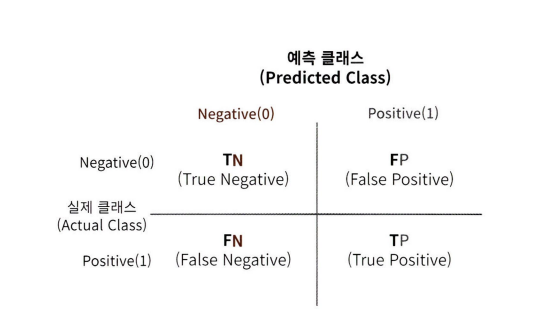

- 명칭: 예측값이 맞았는지(True, False) + **예측** 결과 값이 부정(0=Negative)/긍정(1=Positive)

- FP = 예측 결과가 1=긍정이었지만, 실제로는 0=부정이었던 경우 = Type 1 Error

- FN = 예측 결과가 0=부정이었지만, 실제로는 1=긍정이었던 경우 = Type 2 Error

사이킷런 : **confusion_matrix() API** 제공 = 오차 행렬 구할 수 있음!

- ex. 정확도 예제에서 다룬 MyFakeClassifier의 예측 성능 지표를 오차 행렬로 표현해보기

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred) #인자로 (실제 결과, 예측 결과) 입력력
# 결과: 오차 행렬을 배열 형태로 출력함

array([[405,   0],
       [ 45,   0]])

> 결과 
- 출력된 행렬: ndarray 형태
- 상단 도표와 동일한 위치 = FN = 부정 예측, 실제값 긍정 오류 = 45개가 존재
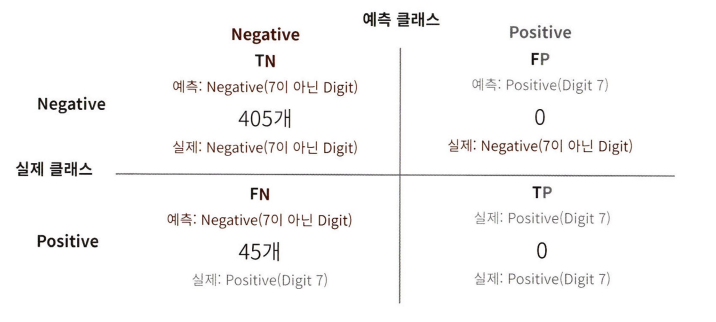


- 위의 값들을 조합해 정확도 / 정밀도 / 재현율 알 수 O
 - ex. 정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수  = (TN + TP)/(TN + FP + FN + TP)

- 이진 분류 모델의 경우: 중점적으로 찾아야 하는, 매우 적은 수의 결괏값에 Positive=1 부여
 - ex. 테러리스트, 사기 행위... = 1
 - 데이터 기반 ML 알고리즘: 많은 수를 가지고 있는 Negative로 예측하는 경향이 강해짐 > TN 상승 / TP 감소 & FP 감소
 - 즉, Positive에 대한 예측 정확도 판단 못한 채 Negative에 대한 예측 정확도만으로도 정확도 매우 높게 나타나는 수치적인 판단 오류 일어남
> 불균형한 데이터셋에서 정확도만으로 모델 신뢰도 떨어질 수 있음

>>불균형한 데이터셋의 경우 **정밀도, 재현율** 사용

## 03. 정밀도(Precision)와 재현율(Recall)
: Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춤 평가 지표

- TP 값이 없다면? 정밀도, 재현율 값 모두 0

**정밀도 = TP / (FP  + TP)** = 양성 예측도
 - 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
  - 분모 (FP  + TP) = 예측을 Positive로 한 모든 데이터 건수
  - 분자 TP = 예측과 실제 값이 Positive로 일치한 데이터 건수
 - TP 높이고 FP 낮추는 데 초점
 - 사이킷런의 **precision_score()**

**재현율 = TP / (FN  + TP)** = 민감도 = TRR (True Positive Rate)
 - 실제값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
  - 분모 (FN  + TP) = 실제 값이 Positive인 모든 데이터 건수
  - 분자 TP = 예측과 실제 값이 Positive로 일치한 데이터 건수
 - TP 높이고 FN 낮추는 데 초점
  - 사이킷런의 **recall_score()**


- 재현율과 정밀도: 서로 보완적인 지표
- 가장 좋은 성능 평가: 둘 모두 높은 수지 / 어느 한 평가 지표만 매우 높다면 바람직하지 X


- 이진 분류 모델의 업무 특성에 따라 정밀도와 재현율 지표 중 특정 평가 지표가 더 중요한 지표로 간주될 수 있음
 - 재현율이 더 중요 지표(일반적) : 실제 Positive 양성 데이터를 Negative로 잘못 판단 시 업무상 큰 영향 발생하는 경우  
   - ex. 암 판단 모델 / 금융 사기 적발 모델
 - 정밀도가 더 중요 지표 : 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향 발생하는 경우
    - ex. 스팸 메일(Positive) 여부 판단하는 모델

- 타이타닉 예제: 오차 행렬 밋 정밀도, 재현율 모두 구해서 예측 성능 평가하기

이전의 평가 지표 모두 호출하는 get_clf_eval() 함수 만들기

In [7]:
# 이전의 평가 지표 모두 호출하는 get_clf_eval() 함수 만들기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision,recall))

- 로지스틱 회귀 기반으로 타이타닉 생존자 예측 후 ,confusion matrix, accuracy, precision, recall 평가 수행

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 우너본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('/content/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 정밀도/재현율 트레이드오프

분류하려는 업무 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 : 분류의 결정 임곗값(Threshold) 조정해 정밀도/재현율의 수치 높일 수 있음
- but, 둘은 상호 보완적 평가 지표 > 하나를 강제로 높이면 하나는 떨어지기 쉬움 
= **정밀도/재현율의 트레이드오프(Trade_off)**

- 사이킷런의 분류 알고리즘 : 예측 데이터가 특정 레이블(Label, 결정 클래스 값)에 속하는지 계산하기 위해 개별 레이블별로 결정 확률 구함(0: 90%, 1: 10%) > 예측 확률이 큰 레이블 값으로 예측(0으로 예측)
 - 일반적인 임곗값 : 0.5 = 50%

- predict_proba() 메서드 : 개별 데이터별로 예측 확률 반환하는 메서드
 - 학습 완료된 사이킷런 Classifier 객체에서 호출 가능
 - predict_proba(테스트 피처 데이터셋) > 테스트 피처 레코드의 개별 클래스 예측 확률 반환
 - cf. predict(), but return 값: 클래스 값 X, 예측 확률 결과
 - 이진 분류에 적용한 반환 결과 ndarray : 첫번째 columns : 클래스 0에 대한 예측 확률 / 두번째 columns : 클래스 1에 대한 예측 확률


- 타이타닉 예체 : predict_proba() 수행 후 반환값 확인 + predict 결과와 비교

In [9]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


- 사이킷런의 predict() : predict_proba() 메서드가 반환하는 확률값을 지닌 ndarray에서 정해진 임곗값(보통 0.5)을 만족한느 ndarray의 칼럼 위치를 최종 예측 클래스로 결정

- 위의 로직 : 사이킷런의 Binarizer 클래스 이용하여 구현하기
 - threshold 변수를 특정 값으로 설정 후 Binarizer 클래스를 객체로 생성
 - Binarizer.fit_transform(넘파이 ndarray) : 지정된 threshold보다 작거나 같으면 0 / 크면 1로 반환함

In [10]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X)) 

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


- Binarizer()을 이용해 사이킷런 predict()의 의사 코드 만들어보기

In [11]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [12]:
# 분류 결정 임곗값 낮추기
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


- 임곗값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가 지표 조사

In [13]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [14]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]  

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0],15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임곗값: ',np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도: ',np.round(precisions[thr_index],3))
print('샘플 임곗값별 재현율: ',np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임곗값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임곗값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


- 정밀도와 재현율 곡선 시각화해보기

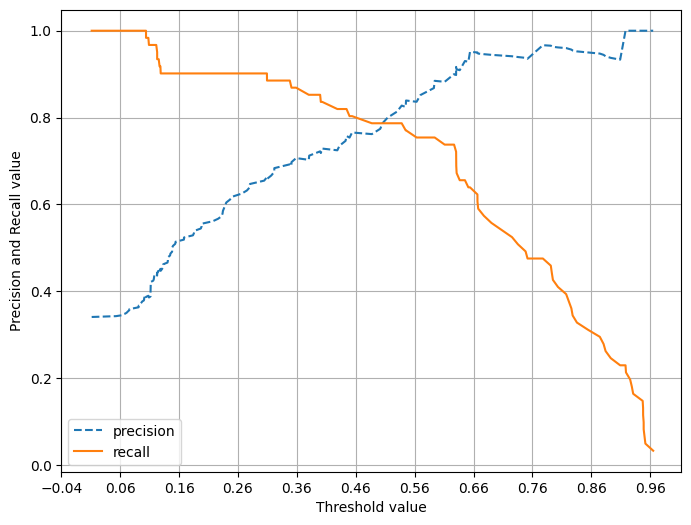

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## 04. F1 스코어

In [16]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [17]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1: 0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


## 05. ROC 곡선과 AUC

In [18]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출.
# thresholds[0]운 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임곗값: ',np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 FPR, TPR 값값
print('샘플 임곗값별 FPR: ',np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR: ',np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


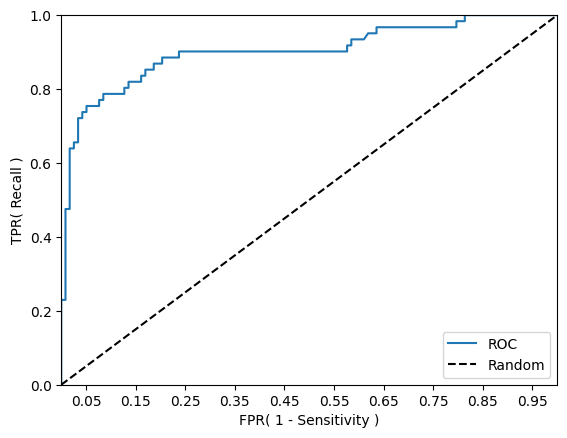

In [19]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정 등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:,-1])

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_test, pred))
print("정확도:", np.round(accuracy_score(y_test, pred), 4))
print("정밀도:", np.round(precision_score(y_test, pred), 4))
print("재현율:", np.round(recall_score(y_test, pred), 4))

[[104  14]
 [ 13  48]]
정확도: 0.8492
정밀도: 0.7742
재현율: 0.7869


In [22]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))